In [1]:
from pymongo import MongoClient
import logging
from gensim.corpora import BleiCorpus
from gensim.models import LdaModel
from gensim import corpora
import os
import time
import multiprocessing
import sys
import string
import pickle
import pandas as pd
import numpy as np
import random
#import nltk
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from operator import itemgetter
from collections import Counter
from sklearn import metrics
from sklearn.feature_extraction import text
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import LSHForest
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
% matplotlib inline

In [15]:
# connect to mongo client
client = MongoClient()
# connects to full collection of 2 million reviews
#wine_info = client.wines.wine_info
# connects to collection of compacted wine names but still separated by year
#c_wines = client.wines.consolidated_wines
# connect to collection of wine names with years stripped
#no_year_wines = client.wines.stripped_year_wines
red_corpus_collection = client.wines.red_corpus_collection

In [74]:
def consolidate_wines(dataframe):
    
    """
    Takes in a dataframe and groups by the wine name; creates lists containing the wine name, all of its reviews 
    concatenated into one string, the varietal, the year, and the average review points
    """
    
    review_text = []
    avg_review_points = []
    wine_name = []
    wine_varietal = []
    wine_year = []


    for wine, iterables in dataframe.groupby('wine/name'):

        # append wine name
        wine_name.append(wine)

        # combine all wine reviews in one string and append
        review_text.append(' '.join(iterables['review/text'].values))

        # append wine varietal
        wine_varietal.append(iterables['wine/variant'].values[0])

        # append wine year
        wine_year.append(iterables['wine/year'].values[0])

        # append average review score
        avg_review_points.append(np.nanmean(iterables['review/points'].values))   
        
    keys = ['wine/name', 'wine/variant', 'review/text', 'review/points', 'wine/year']
    individual_wines = zip(wine_name, wine_varietal, review_text, avg_review_points, wine_year)
        
    return [dict(zip(keys, wine)) for wine in individual_wines]

In [3]:
def vectorize_text(x):
    additional_stop_words = ['wine', 'nose', 'br', 'years', 'time', 'hour', 'bottle']
    additional_stop_words.extend(range(2010))
    additional_stop_words.extend(string.punctuation)
    stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

    vectorizer = text.TfidfVectorizer(min_df=1, stop_words=stop_words, ngram_range=(1,2))
    tfidf_reviews = vectorizer.fit_transform(x)
    print 'Shape of resulting tf-idf vectors: {0}'.format(tfidf_reviews.shape)
    
    return tfidf_reviews, vectorizer

### Begin with all reviews

In [33]:
# pull all reviews in without id
all_reviews = wine_info.find({}, {'_id': 0})
print 'Total number of reviews: {0}'.format(all_reviews.count())

In [ ]:
all_reviews.alive

In [6]:
# create dataframe and replace 'N/A's in the review points column with NaN's in order to take averages on this column
all_df = pd.DataFrame(list(all_reviews))
all_df.replace({'review/points': {'N/A': np.nan}}, inplace=True)
all_df['review/points'] = all_df['review/points'].astype(float)

#### Consolidate multiple reviews per wine into one wine with one review string, and add into mongodb

In [66]:
# call function to get a list of wine dictionaries to send into mongo
#cons_wines = consolidate_wines(all_df)

In [ ]:
# create mongo collection to put wines
#consolidated_wines = client.wines.consolidated_wines
# loop through list and add wine to collection
#for wine in cons_wines:
#    consolidated_wines.save(wine)

### Work with consolidated wine names to strip off year and consolidate on pure name

In [66]:
review_cursor = c_wines.find({}, {'_id': 0})
print 'Count of consolidated wines {0}'.format(review_cursor.count())

Count of consolidated wines 479750


In [ ]:
review_cursor.alive

In [ ]:
# create dataframe of consolidated wines
cwine_df = pd.DataFrame(list(review_cursor))

#### Strip the dates from the wine and consolidate to just the wine brand name

In [ ]:
stripped_names = []

for wine_name in cwine_df['wine/name'].values:
    if wine_name[0] in ['1','2']:
        stripped_names.append(wine_name[4:].strip())
    else:
        stripped_names.append(wine_name)

cwine_df['wine/name'] = stripped_names

In [75]:
names_no_years = consolidate_wines(cwine_df)

In [76]:
len(names_no_years)

199278

In [77]:
# create mongo collection to put wines
#stripped_year_wines = client.wines.stripped_year_wines
# loop through list and add wine to collection
#for wine in names_no_years:
#    stripped_year_wines.save(wine)

### Use truncated SVD to find principal components / PCA

#### Pull in first level of consolidated wines; consolidated reviews per individual wine

In [34]:
reviews = c_wines.find({}, {'_id': 0, 'review/text': 1})
print 'Count of consolidated reviews: {0}'.format(reviews.count())

Count of consolidated reviews: 479750


In [35]:
# create a list of all reviews to vectorize using tf-idf
reviews = [wine['review/text'] for wine in reviews]
print 'Count of wine reviews: {0}'.format(len(reviews))

Count of wine reviews: 479750


In [60]:
#tfidf_reviews, vectorizer = vectorize_text(reviews)

#### Pull in second level of consolidated wines; strip year off wine name to consolidate single wines with different years

In [12]:
new_cursor = no_year_wines.find({}, {'_id': 0})#, 'review/text': 1})
print 'Count of consolidated reviews: {0}'.format(new_cursor.count())

Count of consolidated reviews: 199278


In [5]:
# create a list of reviews from most consolidated wine collection
new_reviews = [wine['review/text'] for wine in new_cursor]
print 'Count of wine reviews: {0}'.format(len(new_reviews))

Count of wine reviews: 199278


In [6]:
tfidf_reviews, vectorizer = vectorize_text(new_reviews)

Shape of resulting tf-idf vectors: (199278, 7380131)


#### SVD with n components

In [58]:
svd = TruncatedSVD(n_components=2)
X_reviews = svd.fit(tfidf_reviews).transform(tfidf_reviews)
print 'Shape of resulting principal components: {0}'.format(X_reviews.shape)

Shape of resulting principal components: (199278, 2)


In [378]:
def store_pickles(filename, to_store):
    with open(filename, 'w') as f:
        pickle.dump(to_store, f)
        
def eat_pickles(filename):
    with open(filename, 'r') as f:
        return pickle.load(f)

In [446]:
#store_pickles('svd_model50.pkl', svd)
#store_pickles('svd_reviews50.pkl', X_reviews)
#store_pickles('tfidf_reviews.pkl', tfidf_reviews)
#store_pickles('vectorizer.pkl', vectorizer)

#### Find the 100 largest word(s) in the array to evaluate as principal components

In [564]:
max_ind = svd.components_[0].argsort()[-100:][::-1]
max_ind2 = svd.components_[1].argsort()[-100:][::-1]

In [10]:
# get feature names from the tf-idf vectorizer
feat_names = vectorizer.get_feature_names()

In [565]:
print 'Principal Component 1: '
print itemgetter(*max_ind)(feat_names)
print
print 'Principal Component 2: '
print itemgetter(*max_ind2)(feat_names)

Principal Component 1: 
(u'fruit', u'good', u'finish', u'nice', u'palate', u'dark', u'red', u'medium', u'cherry', u'tannins', u'black', u'great', u'bit', u'acidity', u'color', u'little', u'oak', u'notes', u'light', u'like', u'spice', u'long', u'really', u'flavors', u'sweet', u'just', u'balanced', u'smooth', u'better', u'drink', u'quite', u'fruits', u'bodied', u'ripe', u'rich', u'balance', u'drinking', u'pinot', u'taste', u'tart', u'big', u'pepper', u'price', u'mouth', u'cherries', u'vanilla', u'earth', u'aromas', u'body', u'deep', u'plum', u'hours', u'lots', u'blackberry', u'red fruit', u'excellent', u'hint', u'soft', u'dry', u'chocolate', u'glass', u'slightly', u'citrus', u'berry', u'complex', u'opened', u'alcohol', u'fresh', u'ruby', u'long finish', u'touch', u'purple', u'decanted', u'structure', u'tasted', u'cab', u'dark fruit', u'apple', u'raspberry', u'day', u'lemon', u'acid', u'bright', u'food', u'floral', u'green', u'nicely', u'mineral', u'lovely', u'fruity', u'medium bodied', u

### Create a scatter plot of the 2 principal components of the most consolidated collection labeled by wine color

In [11]:
new_cursor.alive

False

In [13]:
df = pd.DataFrame(list(new_cursor))

In [101]:
df['wine/variant'].value_counts()[df['wine/variant'].value_counts() > 500]

Pinot Noir                                     21254
Chardonnay                                     16296
Cabernet Sauvignon                             12529
Riesling                                       11106
Red Blend                                      10447
Red Bordeaux Blend                              9079
Syrah                                           7014
Sauvignon Blanc                                 5562
White Blend                                     5553
Merlot                                          5367
Zinfandel                                       4462
Red Rhone Blend                                 3732
Shiraz, Syrah                                   3655
Sangiovese                                      3402
Champagne Blend                                 3312
Tempranillo                                     2818
Cabernet Franc                                  2574
Nebbiolo                                        2546
Grenache Blend, Grenache                      

In [14]:
reds = ['Cabernet Sauvignon', 'Merlot', 'Cabernet Franc', 'Malbec', 'Shiraz, Syrah', 'Syrah', 'Red Blend', 'Grenache',
        'Mourvedre', 'Rhone Red Blend', 'Pinot Noir', 'Gamay', 'Zinfandel', 'Petite Sirah', 'Tempranillo', 'Nebbiolo',
        'Dolcetto', 'Nero d\'Avola', 'Primitivo', 'Barbera', 'Sangiovese', 'Carmenere', 'Pinotage', 'Red Bordeaux Blend', \
       ]

white = ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Champagne Blend', 'Cabernet Franc', \
        'Gew&#252;rztraminer', 'Viognier', 'Chenin Blanc', 'Pinot Gris']

rose = ['Ros&#233; Blend']

In [77]:
color = []

for variant in df['wine/variant'].values:
    if variant in reds:
        color.append('r')
    elif variant in white:
        color.append('y')
    elif variant in rose:
        color.append('m')
    else:
        color.append('w')

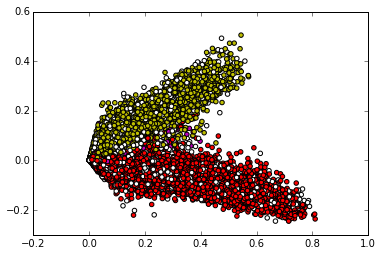

In [25]:
plt.scatter(X_reviews[:,0], X_reviews[:,1], c=color)
plt.show()

#### Set up for Linear SVM classification

In [78]:
X = [(array, color) for (array, color) in zip(X_reviews, color) if color in ['r','y','m']]

In [79]:
y = []

for wine in X:
    if wine[1] == 'r':
        y.append(0)
    elif wine[1] == 'y':
        y.append(1)
    else:
        y.append(2)

In [80]:
X = [array for (array, color) in X]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [82]:
print 'Length of X train set: {0}'.format(len(X_train))
print 'Length of y train set: {0}'.format(len(y_train))
print 'Length of X test set: {0}'.format(len(X_test))
print 'Length of y test set: {0}'.format(len(y_test))

Length of X train set: 97515
Length of y train set: 97515
Length of X test set: 48031
Length of y test set: 48031


In [83]:
svm = LinearSVC(penalty='l2', dual=False, multi_class='ovr').fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [84]:
print metrics.classification_report(y_test, y_pred, target_names = ['class 0', 'class 1', 'class 2'])

             precision    recall  f1-score   support

    class 0       0.89      0.97      0.93     31209
    class 1       0.90      0.80      0.85     16161
    class 2       0.00      0.00      0.00       661

avg / total       0.88      0.90      0.89     48031



/Users/josephdziados/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
from sklearn.cross_validation import ShuffleSplit
from sklearn import cross_validation

cv = ShuffleSplit(len(X), n_iter=7, test_size=0.30, random_state=0)
cv_accuracy = cross_validation.cross_val_score(svm, X, y, scoring='accuracy', cv=cv)
print 'Cross Validation Accuracy: {0:0.2f} ({1:0.2f})'.format(cv_accuracy.mean(), cv_accuracy.std())

Cross Validation Accuracy: 0.90 (0.00)


### LSH - Locality Sensitive Hashing

In [86]:
test_classification = svm.predict(X_reviews)

In [87]:
red_reviews = X_reviews[test_classification == 0]

In [88]:
red_reviews.shape

(136873, 2)

In [ ]:
full_red = svd.inverse_transform(red_reviews)

In [ ]:
full_red.shape

In [28]:
# Initialize a LSH forest and fit the vectorized reviews
lshf = LSHForest(n_neighbors = 500)
lshf.fit(red_reviews)

/Users/josephdziados/anaconda/lib/python2.7/site-packages/sklearn/random_projection.py:369: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (20 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


LSHForest(min_hash_match=4, n_candidates=50, n_estimators=10, n_neighbors=500,
     radius=1.0, radius_cutoff_ratio=0.9, random_state=None)

In [43]:
testv = vectorizer.transform(['full bodied fruity blueberry cherry soft tannins'])

In [44]:
testv.shape

(1, 7380131)

In [45]:
variable = svd.transform(testv)

In [46]:
variable.shape

(1, 20)

In [47]:
neigh = lshf.kneighbors(variable)
#print neigh[0][0][:10] 
print neigh[1][0][:100]

[  5036   7886  76074 129157  52752 126148  38931   3837  57098 110988
  40597  76337  14190  71994  91104  16031  24313 123147   6907  57141
  12277   9460  77368 114886  83382 134641  72407  11404  22396  53491
 131623  44907 128912  67784 106724  75626  32783  43262  20695 105551
  74069 128388  97597 112803 117760 120747  15219  52907 111529 106589
  44360  14381  90941  31245  39279 114319  40170  53974  27790  78738
  27262 134853  24710  35645 111696 137023 119074 113914  28576  71700
  69398 109549  73320 102865 126604 109924  15208  15510  98991  32745
   7020  55781  75128   5784  36230  63288 122641  63769  43462   8554
  71347  38988  24617  36057  60809 134285  77623  78436  49736 112190]


In [48]:
for j in neigh[1][0][:100]:
    for i in range(len(X_reviews)):
        if np.array_equal(X_reviews[i], red_reviews[j]):
            print i, j, new_reviews[i]

7211 5036 Cherry-dominated, with currant and raspberry tones. High acidicy, moderate tannins. Light. Lt spice.
11225 7886 Green pepper and cherry aromas. Earthy cassis and cherry flavors with slightly gritty tannins. Medium, drying finish. Don't buy again The nose is pleasant with blackberry jam aromas, but wine is thin and sharp.<br />$11.99 OH Retail.
107714 76074 light and smooth drinkingwine with very slight acidity No discript simple wine with hints of rasberry, tabacco and dark cherry.
186534 129157 What I'm looking for in a CdP. Current forward on the nose with a light, pleasant barnyard funk. Supple tannins with a moderately wide mouthfeel of current, dark cherry, shoe leather with a hint of metal. Moderate finish leaves an elegant impression.
73195 52752 Light bodied, lovely with burgers. Pleasant medium bodied light cherry, musty richness in aroma This wine is a little gem. Easy to drink, delicate balance. Olive overtone helped pair beautifully with a vegeterian pizza and oth

KeyboardInterrupt: 

### K Means on Principal Components

#### Evaluate inertia to find best number of clusters

In [38]:
inertia_k = []

for num_cluster in range(1,40):
    print 'Running K {0}...'.format(num_cluster)
    km = MiniBatchKMeans(n_clusters = num_cluster)
    km.fit(X_reviews)
    inertia_k.append(km.inertia_)

Running K 1...
Running K 2...
Running K 3...
Running K 4...
Running K 5...
Running K 6...
Running K 7...
Running K 8...
Running K 9...
Running K 10...
Running K 11...
Running K 12...
Running K 13...
Running K 14...
Running K 15...
Running K 16...
Running K 17...
Running K 18...
Running K 19...
Running K 20...
Running K 21...
Running K 22...
Running K 23...
Running K 24...
Running K 25...
Running K 26...
Running K 27...
Running K 28...
Running K 29...
Running K 30...
Running K 31...
Running K 32...
Running K 33...
Running K 34...
Running K 35...
Running K 36...
Running K 37...
Running K 38...
Running K 39...


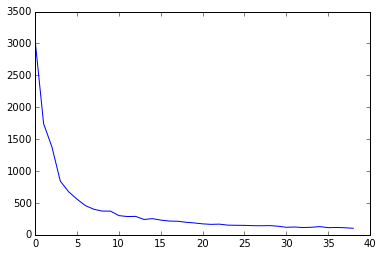

In [39]:
plt.plot(inertia_k)

#### Fit k-means using minibatch on best number of clusters

In [30]:
num_clusters = 25

km = MiniBatchKMeans(n_clusters = num_clusters)
km.fit(X_reviews)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=25,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

#### Loop through and print out each clusters centroid sentence, along with the variant, and the number of people who expressed similar views

In [29]:
clustered_sentences = sorted(zip(km.labels_, X_reviews, new_reviews), key=itemgetter(0))

for num_cluster in range(num_clusters):
    indiv_cluster = [clust_sent for clust_sent in clustered_sentences if clust_sent[0] == num_cluster]
    get_matrix = itemgetter(1) 
    cluster_vector = map(get_matrix, indiv_cluster)
    dist = [metrics.pairwise_distances(vector, km.cluster_centers_[num_cluster]) for vector in cluster_vector]
    min_dist = np.argmin(dist)
    variant = no_year_wines.find({'review/text': indiv_cluster[min_dist][2]}, {'_id': 0, 'wine/variant': 1})
    print 'Centroid {0}\'s Closest Sentence is \"{1}\"'.format(num_cluster + 1, indiv_cluster[min_dist][2].encode('ascii', 'ignore'))
    print 'Variant of wine: {0}'.format(str(variant.next()['wine/variant']))
    print '{0} number of people expressed a similar view'.format(len(cluster_vector))
    print

Centroid 1's Closest Sentence is "This has blackcurrants and raspberries on the nose. Quite rich and full on the palate. Quite forward, easy drinking with good balance and character."
Variant of wine: Red Blend
183349 number of people expressed a similar view

Centroid 2's Closest Sentence is "Deep colour. Not a very dominant nose. OK, perhaps a bit innocuous. PnP served over 2 nights, both showing quite nicely. A lot of purity and complexity on the nose and palate, with another 5 years of very enjoyable drinking ahead of it. If you can find it, and you know it to have been stored properly, buy it, you won't be disappointed. Score Poured deep, purple/red still looking quite young, with a nose of classic cigar and blackcurrent. No sign of jam or over concentrated/cooked fruit here. Refreshing on the palate due to good acid and clean, ripe fruit, this Menzies was beautifully balanced and aged. A long length on the finish only added to the experience. The wine started to break-up a touch 

#### Pick a particular cluster and print out all reviews for that cluster with its variant

In [25]:
clustered_reviews = zip(km.labels_, new_reviews)

for review in clustered_reviews:
    if review[0] == 17:
        print review[1]
        variant = no_year_wines.find({'review/text': review[1]}, {'_id': 0, 'wine/variant': 1})
        print 'Wine Variant: {0}'.format(str(variant.next()['wine/variant']))

Needs quite a bit of time to open up still. Nose of cedar and black fruit gives way to rich boysenberry, oak and chocolate flavors with smoky/meaty undertones. Strong tannins. Long finish. Good now (after a good, long decanting) but will lay down for years.
Wine Variant: Malbec
I had heard great things about this winery from more than one person so I was pumped that my dad gave me a bottle after he got back from WW. This must be their entry level blend as it didn't have much going on except a little bit of fruit and more oak that I would have expected. Mostly cab and merlot . Not sure how much this costs, but I don't think I'll be buying any. 85pts. Needs about an hour to open up, then there is quite a difference. First taste was a little harsh. Set decanted for one hour and the wait is worth it. Scent of fruit and light mineral. Taste of cherry, cola and an anise finish. Smooth yet complex. The four of us are giving this an 88. Young but refined, very elegant. Could use more time or d

KeyboardInterrupt: 

In [24]:
red_reviews = df['review/text'][X_reviews[:,1] < 0].values

In [27]:
red_tfidf, red_vectorizer = vectorize_text(red_reviews)

Shape of resulting tf-idf vectors: (91830, 5539775)


In [30]:
red_svd = TruncatedSVD(n_components=5)
redX_reviews = red_svd.fit(red_tfidf).transform(red_tfidf)
print 'Shape of resulting principal components: {0}'.format(redX_reviews.shape)

Shape of resulting principal components: (91830, 5)


In [31]:
redmax_ind = red_svd.components_[0].argsort()[-100:][::-1]
redmax_ind2 = red_svd.components_[1].argsort()[-100:][::-1]
redmax_ind3 = red_svd.components_[2].argsort()[-100:][::-1]
redmax_ind4 = red_svd.components_[3].argsort()[-100:][::-1]
redmax_ind5 = red_svd.components_[4].argsort()[-100:][::-1]

# get feature names from the tf-idf vectorizer
redfeat_names = red_vectorizer.get_feature_names()

print 'Principal Component 1: '
print itemgetter(*redmax_ind)(redfeat_names)
print
print 'Principal Component 2: '
print itemgetter(*redmax_ind2)(redfeat_names)
print
print 'Principal Component 3: '
print itemgetter(*redmax_ind3)(redfeat_names)
print
print 'Principal Component 4: '
print itemgetter(*redmax_ind4)(redfeat_names)
print
print 'Principal Component 5: '
print itemgetter(*redmax_ind5)(redfeat_names)

Principal Component 1: 

(u'fruit', u'finish', u'good', u'nice', u'dark', u'palate', u'red', u'cherry', u'tannins', u'medium', u'black', u'great', u'bit', u'little', u'color', u'oak', u'spice', u'notes', u'acidity', u'long', u'like', u'really', u'smooth', u'flavors', u'just', u'balanced', u'better', u'sweet', u'drink', u'fruits', u'light', u'bodied', u'ripe', u'pinot', u'drinking', u'quite', u'big', u'pepper', u'rich', u'balance', u'earth', u'cherries', u'hours', u'plum', u'blackberry', u'taste', u'deep', u'chocolate', u'vanilla', u'red fruit', u'cab', u'decanted', u'price', u'berry', u'tart', u'mouth', u'purple', u'dark fruit', u'ruby', u'lots', u'aromas', u'opened', u'soft', u'body', u'alcohol', u'structure', u'glass', u'raspberry', u'excellent', u'complex', u'long finish', u'leather', u'hint', u'day', u'tasted', u'berries', u'earthy', u'slightly', u'black fruit', u'young', u'nicely', u'tobacco', u'open', u'tannin', u'touch', u'right', u'medium bodied', u'black cherry', u'think', u's

### Topic Modeling

In [64]:
tags_collection = client.wines.tags_collection

In [67]:
review_count = review_cursor.count()

In [68]:
def load_stopwords():
    more_stopwords = ['\'s', 'wine', 'nose', 'br', 'drink', 'year', 'time']
    stopwords = {}
    with open('stopwords.txt', 'rU') as f:
        for line in f:
            stopwords[line.strip()] = 1
        for char in string.punctuation:
            stopwords[char] = 1
    for more_words in more_stopwords:
        stopwords[more_words] = 1

    return stopwords


def worker(identifier, skip, count):
    done = 0
    start = time.time()

    stopwords = load_stopwords()

    batch_size = 100
    for batch in range(0, count, batch_size):
        reviews_cursor = no_year_wines.find().skip(skip + batch).limit(batch_size)
        for review in reviews_cursor:
            words = []
            sentences = nltk.sent_tokenize(review["review/text"].lower())

            for sentence in sentences:
                tokens = nltk.word_tokenize(sentence)
                text = [word for word in tokens if word not in stopwords]
                tagged_text = nltk.pos_tag(text)

                for word, tag in tagged_text:
                    words.append({"word": word, "pos": tag})

            tags_collection.insert({
                "wine/name": review["wine/name"],
                "wine/variant": review["wine/variant"],
                "review/points": review['review/points'],
                "review/text": review["review/text"],
                "words": words
            })

            done += 1
            if done % 100 == 0:
                end = time.time()
                print 'Worker' + str(identifier) + ': Done ' + str(done) + ' out of ' + str(count) + ' in ' + (
                    "%.2f" % (end - start)) + ' sec ~ ' + ("%.2f" % (done / (end - start))) + '/sec'
                sys.stdout.flush()
                
def main():
    reviews_cursor = no_year_wines.find()
    count = reviews_cursor.count()
    workers = 3
    batch = count / workers
    left = count % workers

    jobs = []
    for i in range(workers):
        size = count / workers
        if i == (workers - 1):
            size += left
        p = multiprocessing.Process(target=worker, args=((i + 1), i * batch, size))
        jobs.append(p)
        p.start()

    for j in jobs:
        j.join()
        print '%s.exitcode = %s' % (j.name, j.exitcode)

In [69]:
main()

Process-1.exitcode = -9
Process-2.exitcode = -9Worker3: Done 100 out of 66426 in 12.89 sec ~ 7.76/sec
Worker2: Done 100 out of 66426 in 16.17 sec ~ 6.18/sec
Worker1: Done 100 out of 66426 in 24.80 sec ~ 4.03/sec
Worker3: Done 200 out of 66426 in 34.11 sec ~ 5.86/sec
Worker2: Done 200 out of 66426 in 45.53 sec ~ 4.39/sec
Worker1: Done 200 out of 66426 in 38.62 sec ~ 5.18/sec
Worker3: Done 300 out of 66426 in 41.71 sec ~ 7.19/sec
Worker2: Done 300 out of 66426 in 90.65 sec ~ 3.31/sec
Worker1: Done 300 out of 66426 in 52.77 sec ~ 5.68/sec
Worker3: Done 400 out of 66426 in 45.53 sec ~ 8.79/sec
Worker2: Done 400 out of 66426 in 104.30 sec ~ 3.84/sec
Worker1: Done 400 out of 66426 in 64.43 sec ~ 6.21/sec
Worker3: Done 500 out of 66426 in 50.27 sec ~ 9.95/sec
Worker2: Done 500 out of 66426 in 118.15 sec ~ 4.23/sec
Worker1: Done 500 out of 66426 in 92.73 sec ~ 5.39/sec
Worker3: Done 600 out of 66426 in 67.59 sec ~ 8.88/sec
Worker2: Done 600 out of 66426 in 184.38 sec ~ 3.25/sec
Worker1: Done 6

In [100]:
corpus_collection = client.wines.corpus_collections

reviews_cursor = tags_collection.find()
reviewsCount = reviews_cursor.count()
reviews_cursor.batch_size(5000)

lem = WordNetLemmatizer()

done = 0
start = time.time()

for review in reviews_cursor:
    nouns = []
    words = [word for word in review["words"] if word["pos"] in ["NN"]]

    for word in words:
        nouns.append(lem.lemmatize(word["word"]))

    corpus_collection.insert({
        "wine/name": review["wine/name"],
        "wine/variant": review["wine/variant"],
        "review/points": review['review/points'],
        "review/text": review["review/text"],
        "words": nouns
    })

    done += 1
    if done % 100 == 0:
        end = time.time()
        os.system('cls')

Worker3: Done 8600 out of 159918 in 730.30 sec ~ 11.78/sec
Worker2: Done 8700 out of 159916 in 860.99 sec ~ 10.10/sec
Worker1: Done 8700 out of 159916 in 691.54 sec ~ 12.58/sec
Worker3: Done 8700 out of 159918 in 738.65 sec ~ 11.78/sec
Worker2: Done 8800 out of 159916 in 868.22 sec ~ 10.14/sec
Worker1: Done 8800 out of 159916 in 699.59 sec ~ 12.58/sec
Worker3: Done 8800 out of 159918 in 744.27 sec ~ 11.82/sec
Worker2: Done 8900 out of 159916 in 890.50 sec ~ 9.99/sec
Worker1: Done 8900 out of 159916 in 708.04 sec ~ 12.57/sec
Worker3: Done 8900 out of 159918 in 752.12 sec ~ 11.83/sec
Worker2: Done 9000 out of 159916 in 901.35 sec ~ 9.99/sec
Worker1: Done 9000 out of 159916 in 714.51 sec ~ 12.60/sec
Worker3: Done 9000 out of 159918 in 761.11 sec ~ 11.82/sec
Worker2: Done 9100 out of 159916 in 910.09 sec ~ 10.00/sec
Worker1: Done 9100 out of 159916 in 723.78 sec ~ 12.57/sec
Worker3: Done 9100 out of 159918 in 774.67 sec ~ 11.75/sec
Worker2: Done 9200 out of 159916 in 917.93 sec ~ 10.02/sec

In [16]:
class Corpus(object):
    def __init__(self, cursor, reviews_dictionary, corpus_path):
        self.cursor = cursor
        self.reviews_dictionary = reviews_dictionary
        self.corpus_path = corpus_path

    def __iter__(self):
        self.cursor.rewind()
        for review in self.cursor:
            yield self.reviews_dictionary.doc2bow(review["words"])

    def serialize(self):
        BleiCorpus.serialize(self.corpus_path, self, id2word=self.reviews_dictionary)

        return self


class Dictionary(object):
    def __init__(self, cursor, dictionary_path):
        self.cursor = cursor
        self.dictionary_path = dictionary_path

    def build(self):
        self.cursor.rewind()
        dictionary = corpora.Dictionary(review["words"] for review in self.cursor)
        dictionary.filter_extremes(keep_n=10000)
        dictionary.compactify()
        corpora.Dictionary.save(dictionary, self.dictionary_path)

        return dictionary


class Train:
    def __init__(self):
        pass

    @staticmethod
    def run(lda_model_path, corpus_path, num_topics, id2word):
        corpus = corpora.BleiCorpus(corpus_path)
        lda = LdaModel(corpus, num_topics=num_topics, id2word=id2word)
        lda.save(lda_model_path)

        return lda


def main():
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    dictionary_path = "models/dictionary.dict"
    corpus_path = "models/corpus.lda-c"
    lda_num_topics = 25
    lda_model_path = "models/lda_model_50_topics.lda"

    reviews_cursor = red_corpus_collection.find()

    dictionary = Dictionary(reviews_cursor, dictionary_path).build()
    Corpus(reviews_cursor, dictionary, corpus_path).serialize()
    Train.run(lda_model_path, corpus_path, lda_num_topics, dictionary)

In [17]:
main()

In [18]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

dictionary_path = "models/dictionary.dict"
corpus_path = "models/corpus.lda-c"
lda_num_topics = 25
lda_model_path = "models/lda_model_50_topics.lda"

dictionary = corpora.Dictionary.load(dictionary_path)
corpus = corpora.BleiCorpus(corpus_path)
lda = LdaModel.load(lda_model_path)

i = 0
for topic in lda.show_topics(num_topics=lda_num_topics):
    print '#' + str(i) + ': ' + topic
    i += 1

#0: 0.015*tempranillo + 0.013*spanish + 0.010*und + 0.008*leather + 0.006*tobacco + 0.006*dry + 0.006*der + 0.006*mit + 0.006*aloha + 0.006*food
#1: 0.012*en + 0.012*bedrock + 0.011*fresh + 0.010*floral + 0.009*mineral + 0.008*village + 0.007*elegant + 0.007*van + 0.007*pure + 0.007*beautiful
#2: 0.018*cdp + 0.015*licorice + 0.012*grenache + 0.012*tar + 0.011*garrigue + 0.010*raspberry + 0.007*floral + 0.007*tight + 0.006*leather + 0.006*kirsch
#3: 0.030*bordeaux + 0.016*cedar + 0.010*cassis + 0.010*leather + 0.009*classic + 0.009*tobacco + 0.008*pencil + 0.007*dry + 0.006*beautiful + 0.006*baudry
#4: 0.043*syrah + 0.015*rhone + 0.012*meat + 0.009*smoke + 0.007*bacon + 0.007*meaty + 0.006*floral + 0.006*blueberry + 0.006*raspberry + 0.006*cdr
#5: 0.018*le + 0.015*vin + 0.013*la + 0.011*en + 0.011*une + 0.010*avec + 0.009*nez + 0.009*est + 0.008*ce + 0.007*bouche
#6: 0.085*zin + 0.022*zinfandel + 0.015*jammy + 0.014*raspberry + 0.013*turley + 0.012*heat + 0.010*hot + 0.008*fruity + 0.00